In [1]:
# Import nessesary libraries
import pandas as pd
import glob
import csv
import re
from collections import Counter
import itertools

# NLP libraries
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import bigrams as nltkbigrams
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
from gensim.corpora import MmCorpus
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

# Visualisation libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import networkx as nx
import pyLDAvis
import pyLDAvis.gensim

## Importing saved articles

In [2]:
# Read the list of Women EE names
df = pd.read_csv('WE_name_country.csv', names = ['name', 'country'])
#Save list of countries
country_list = df.country.unique()

# Import all CSV files from all Wiki articles and save them to one list
articles_df = pd.DataFrame({'articles': [], 'country': []})

for country in country_list:
    filename = country +'_*.csv'
    files = glob.glob('WE_articles/' + filename)
    
    all_articles = []
    for file in files:
        read_handle = open(file, "r")
        text = list(csv.reader(read_handle, delimiter=","))        
        for article in text[1:]:
            all_articles.append(article[1])     
    
    country_df = pd.DataFrame({'articles': all_articles, 'country': country})
    articles_df = pd.concat([articles_df, country_df], ignore_index=True)

# How many articles has been read
print('Number of articles:', len(articles_df))

# Drop duplicates
articles_df = articles_df.drop_duplicates()

# Count the number of rows after
lenAfter = len(articles_df)
print("After de-duplication: " + str(lenAfter))

# Number of articles in initial list by country
articles_df.groupby('country').count()

Number of articles: 2046
After de-duplication: 1594


,articles
country,
Austria,82
Belgium,144
France,475
Germany,508
Lienchshtein,14
Luxembourg,23
Monaco,11
Netherlands,206
Switzerland,131


## Preprocessing and tokenisation

In [12]:
# Based on https://www.geeksforgeeks.org/nlp-gensim-tutorial-complete-guide-for-beginners/

all_tokens = []

# import stopwords
stop_words = stopwords.words('english') + ['de', 'since', 'le', 'la', 'et', 'also', 'isbn', 'th']

wnl = WordNetLemmatizer()

# Check for latin alphabet 
# https://stackoverflow.com/questions/27084617/detect-strings-with-non-english-characters-in-python
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True


for article in articles_df['articles']:
    # Removing section headers and new line breaks
    text = re.sub("==.*==",'', article)
    text = re.sub("\n",'', text)
    
    # Convert a document into a list of tokens 
    # This lowercases, tokenizes, removes numerical values
    tokens = simple_preprocess(text)
    
    doc_out = []
    for word in tokens:    
        if word not in stop_words:  # to remove stopwords
            if isEnglish(word):
                Lemmatized_Word = wnl.lemmatize(word)  # lemmatize
                doc_out.append(Lemmatized_Word)
    
    all_tokens.append(doc_out)

# Print out infromation about articles and number of tokens for top 15
print('Tokens groups:', len(all_tokens),'\n')
print("{0:7}{1:10}".format("-No-","--Tokens--"))
for x, tokens in enumerate(all_tokens[:15]):
    print("{0:3}{1:10}".format(x + 1, len(tokens)))

Tokens groups: 1594 

-No-   --Tokens--
  1       107
  2       123
  3       195
  4       127
  5       108
  6        61
  7       671
  8       169
  9       190
 10       223
 11        43
 12       206
 13        12
 14       135
 15       284


## Dictionary and corpus

In [13]:
# create dictionary - a map of unique tokens
dictionary = Dictionary(all_tokens)
dictionary.filter_extremes(no_below = 30, no_above = 0.8)
print('Dictionary length:', len(dictionary.keys()))

# 100 tokens by frequency for cleaned up dictionary
t_most_freq = dictionary.most_common(100)
print('Top 20 tokens by frequency\n')

num = 1
for t, f in t_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1


# Create a MmCorpus: corpus
corpus = [dictionary.doc2bow(token) for token in all_tokens]
print('\nCorpus created. \nCorpus length:', len(corpus))

Dictionary length: 1174
Top 20 tokens by frequency

1. party - 3286
2. election - 2787
3. german - 2422
4. french - 1721
5. elected - 1715
6. state - 1676
7. committee - 1673
8. council - 1512
9. minister - 1491
10. group - 1479
11. national - 1466
12. federal - 1409
13. became - 1382
14. board - 1365
15. served - 1340
16. parliament - 1302
17. parliamentary - 1292
18. university - 1240
19. president - 1221
20. first - 1167

Corpus created. 
Corpus length: 1594


In [14]:
# Writing top 250 tokens for all articles by frequency to a CSV file
top_df = pd.DataFrame(dictionary.most_common(250))
top_df.columns = ['token', 'frequency']
top_df.to_csv('output/WE_frequency_top_250.csv', index = False, header = True)

/Users/daryasolomenko/anaconda3/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


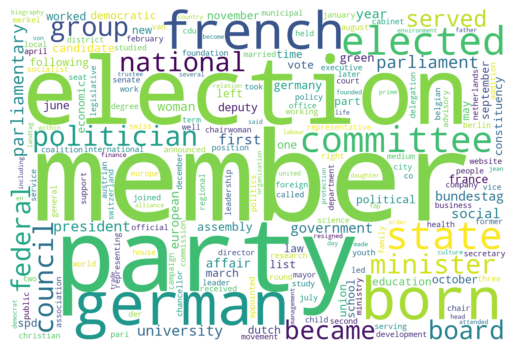

In [28]:
# WordCloud based on all tokens
# combine all tokens into one string
text = ""
for token_list in all_tokens:
    for token in token_list: 
        text = text + " " + token

# Create and generate a word cloud image:
# https://www.datacamp.com/tutorial/wordcloud-python - parameters
wordcloud = WordCloud(background_color = "white", collocations = False, 
                      width = 1500, height = 1000, stopwords = None).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Bigrams

In [15]:
article_bigram = [list(nltkbigrams(article)) for article in all_tokens]

# Flatten list of bigrams
bigrams_list = list(itertools.chain(*article_bigram))

# Create counter of words in bigrams list
bigram_counts = Counter(bigrams_list)
print('Number of unique bigrams in the articles:', len(bigram_counts))

bigram_df = pd.DataFrame(bigram_counts.most_common(100), columns=['bigram', 'count'])

bigram_df.head(10)

Number of unique bigrams in the articles: 181952


,bigram,count
0,"(member, board)",607
1,"(national, assembly)",526
2,"(federal, election)",478
3,"(parliamentary, group)",471
4,"(member, bundestag)",388
5,"(democratic, party)",384
6,"(german, politician)",372
7,"(house, representative)",362
8,"(became, member)",318
9,"(legislative, election)",306


In [16]:
# Writing top 100 bigrams for all articles by frequency to a CSV file
bigram_df.to_csv('output/WE_bigrams_100.csv', index = False, header = True)

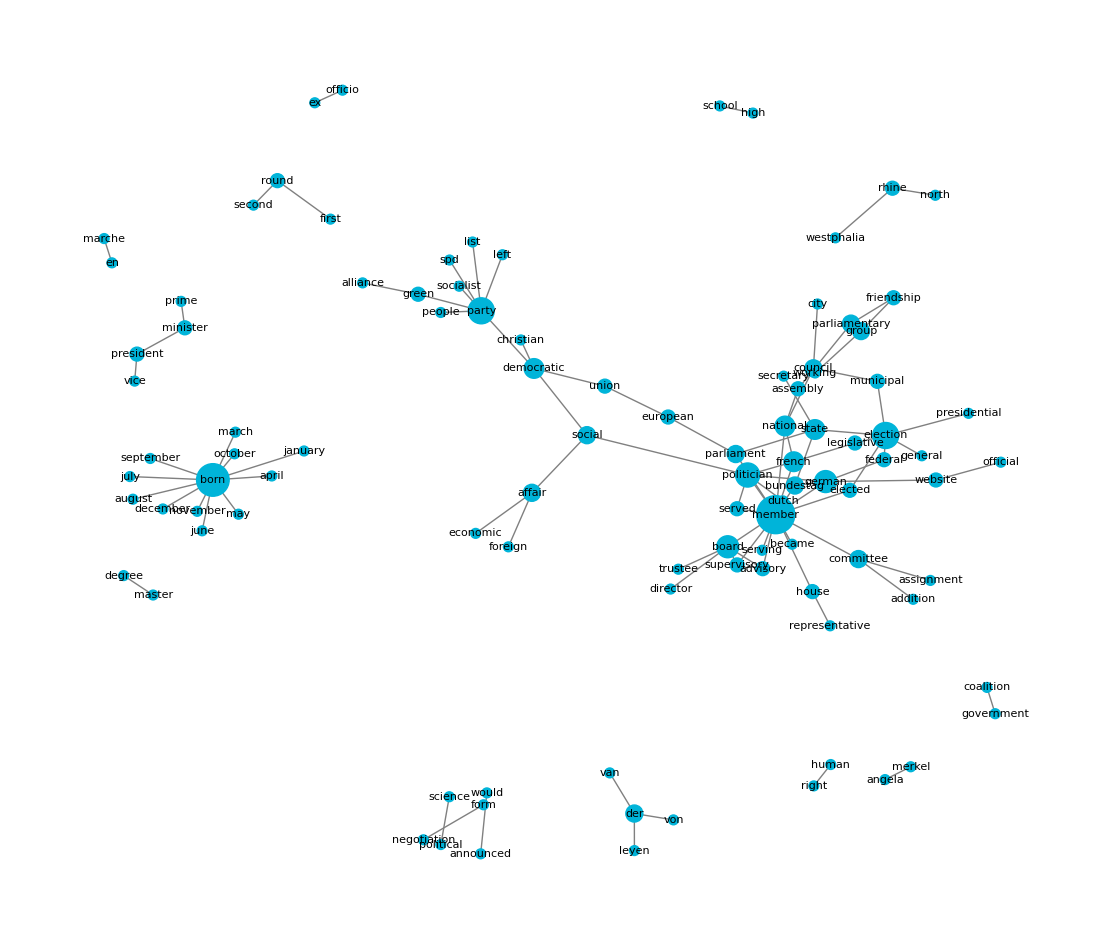

In [17]:
# Bigram visualisation
# https://github.com/oliviatan29/network_analysis/blob/main/Network%20Analysis%20-%20Indonesian%20Food%20Ingredients.ipynb
# Create dictionary of edges and their weights
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))
    
# Use node degree as the node size

fig, ax = plt.subplots(figsize=(14, 12))

pos = nx.spring_layout(G, k=2)

d = dict(G.degree)

nx.draw(G, pos,
        font_size = 8,
        width = 1,
        edge_color = 'grey',
        node_color = '#00b4d9',
        with_labels = True, 
        nodelist = list(d.keys()), 
        node_size = [v * 50 for v in d.values()])
plt.show()

In [51]:
# https://github.com/oliviatan29/network_analysis/tree/main
# Define get_nodes_and_nbrs()
def get_nodes_and_nbrs(G, nodes_of_interest):
    """
    Returns a subgraph of the graph `G` with only the `nodes_of_interest` and their neighbors.
    """
    nodes_to_draw = []
    # Iterate over the nodes of interest
    for n in nodes_of_interest:
        # Append the nodes of interest to nodes_to_draw
        nodes_to_draw.append(n)
        # Iterate over all the neighbors of node n
        for nbr in G.neighbors(n):
            # Append the neighbors of n to nodes_to_draw
            nodes_to_draw.append(nbr)
    return G.subgraph(nodes_to_draw)

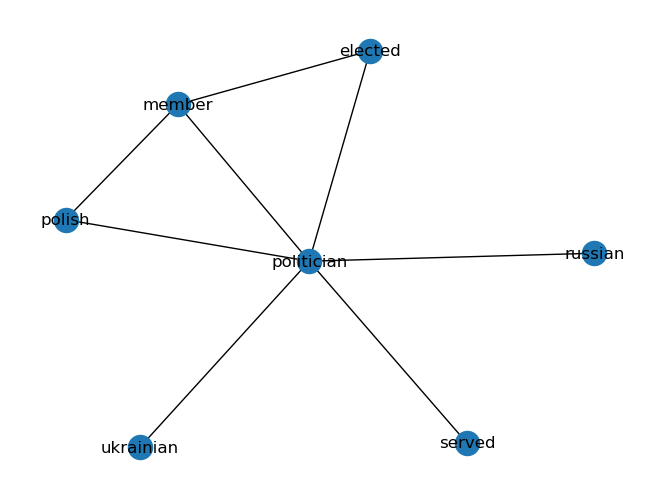

In [52]:
# Extract the subgraph with the nodes of interest: T_draw
T_draw = get_nodes_and_nbrs(G, ['politician'])

# Draw the subgraph to the screen
nx.draw(T_draw, with_labels=True)
plt.show()

In [53]:
# Or as a list
list(G.adj['politician'])

['polish', 'russian', 'member', 'served', 'ukrainian', 'elected']

## Trigrams

In [18]:
# Train a toy phrase model on our training corpus.
phrase_model = Phrases(all_tokens, min_count = 10, threshold = 50, connector_words = ENGLISH_CONNECTOR_WORDS)

# Train trigram model on all tockets
trigram  = Phrases(phrase_model[all_tokens], min_count = 10)
#print(trigram)

# Create a list of all trigrams
trigram_list = []
for token in all_tokens:
    trigrams_ = [t for t in trigram[phrase_model[token]] if t.count('_')==2]
    if len(trigrams_) > 0:
        trigram_list.append(trigrams_) 
    
print('Total number of documents with trigrams:', len(trigram_list))

# create dictionary of trigrams
trigram_dic = Dictionary(trigram_list)
print('Number of unique trigrams:', len(trigram_dic.keys()))

# Top 100 tigrams by frequency in all articles
trigram_most_freq = trigram_dic.most_common(100)
print('\nTop 20 trigrams by frequency\n')

num = 1
for t, f in trigram_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1

Total number of documents with trigrams: 1223
Number of unique trigrams: 197

Top 20 trigrams by frequency

1. social_democratic_party - 211
2. french_legislative_election - 171
3. addition_committee_assignment - 154
4. parliamentary_friendship_group - 149
5. member_board_trustee - 136
6. member_house_representative - 120
7. french_national_assembly - 109
8. von_der_leyen - 105
9. christian_democratic_union - 103
10. ex_officio_member - 102
11. official_website_german - 97
12. national_assembly_france - 94
13. north_rhine_westphalia - 90
14. member_supervisory_board - 89
15. bundestag_biography_english - 78
16. free_democratic_party - 73
17. chancellor_angela_merkel - 69
18. government_prime_minister - 58
19. en_marche_lrem - 57
20. university_applied_science - 55


In [20]:
# Writing top 50 trigrams for all articles by frequency to a CSV file
top_trigram_df = pd.DataFrame(trigram_most_freq[:50])
top_trigram_df.columns = ['trigram', 'frequency']
top_trigram_df.to_csv('output/WE_trigrams_50.csv', index = False, header = True)

## Optimal number of topics

https://radimrehurek.com/gensim/models/coherencemodel.html

Best coherence for umass is typically the minimum. Best coherence for c_v is typically the maximum. Umass is faster than c_v, but in my experience c_v gives better scores for optimal number of topics. This is not a hard decision rule. It depends on the use case. If you're evaluating topics for human readability you would probably want to compare a few models with low umass to see how the top keywords look with something like pyLDAvis. Vice versa for c_v. (https://groups.google.com/g/gensim/c/Ybja9B15F1E?pli=1)

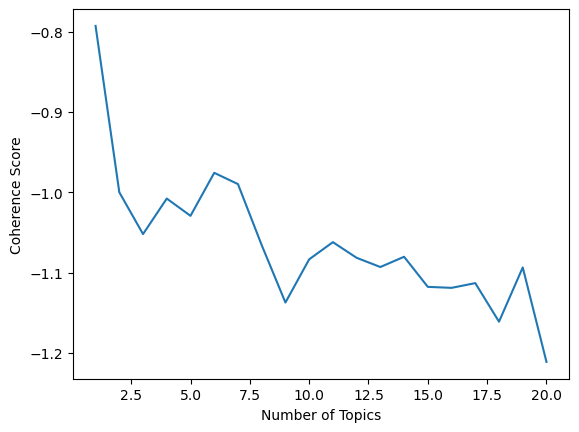

In [21]:
topics = []
score = []
for i in range(1,21,1):
    lda_model = LdaMulticore(corpus = corpus, id2word = dictionary, 
                             iterations = 10, num_topics = i, 
                             workers = 4, passes = 10, 
                             random_state = 100)
    cm = CoherenceModel(model = lda_model, corpus = corpus, dictionary = dictionary, 
                        coherence='u_mass')
    topics.append(i)
    score.append(cm.get_coherence())
    
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [ ]:
# Calculating the coherence score using C_v
# also cm.get_coherence_per_topic()
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, 
                             iterations=10, num_topics=i, 
                             workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, texts = all_tokens, corpus=corpus, 
                        dictionary=dictionary, 
                        coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())
    
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

## LDA model

In [22]:
# Train our lda model
lda_model = LdaMulticore(corpus = corpus, id2word = dictionary, 
                         iterations = 10, num_topics = 9, 
                         workers = 4, passes = 10, 
                         random_state = 100)

cm = CoherenceModel(model = lda_model, corpus = corpus, dictionary = dictionary, 
                        coherence='u_mass')  
cm_score = cm.get_coherence()

print('LDA model coherence score:', cm_score)

# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model.print_topics(-1):
    print('\nTopic: {} \nWords: {}'.format(idx, topic))

LDA model coherence score: -1.1332981325687501

Topic: 0 
Words: 0.043*"committee" + 0.032*"parliamentary" + 0.027*"group" + 0.027*"german" + 0.024*"french" + 0.024*"election" + 0.019*"bundestag" + 0.018*"assembly" + 0.016*"parliament" + 0.016*"affair"

Topic: 1 
Words: 0.024*"state" + 0.021*"german" + 0.020*"elected" + 0.018*"party" + 0.016*"belgian" + 0.015*"became" + 0.014*"green" + 0.014*"election" + 0.013*"parliament" + 0.013*"bundestag"

Topic: 2 
Words: 0.040*"party" + 0.027*"election" + 0.026*"german" + 0.019*"left" + 0.015*"state" + 0.014*"elected" + 0.013*"berlin" + 0.012*"green" + 0.012*"germany" + 0.011*"candidate"

Topic: 3 
Words: 0.017*"french" + 0.014*"france" + 0.013*"paris" + 0.012*"director" + 0.010*"board" + 0.008*"year" + 0.008*"president" + 0.008*"first" + 0.007*"minister" + 0.007*"company"

Topic: 4 
Words: 0.012*"woman" + 0.010*"year" + 0.009*"german" + 0.009*"business" + 0.008*"university" + 0.008*"one" + 0.008*"european" + 0.007*"company" + 0.007*"der" + 0.007

## LDA Visualisation

In [23]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.102557  0.057427       1        1  14.069672
7     -0.058235  0.093155       2        1  13.771136
6      0.075872 -0.004395       3        1  13.321369
5     -0.019233 -0.135850       4        1  12.219748
3      0.101941 -0.051332       5        1  10.960126
2     -0.042603  0.038632       6        1   9.608847
0     -0.154828 -0.035482       7        1   9.073091
8      0.028386 -0.001245       8        1   8.848088
1     -0.033858  0.039090       9        1   8.127923, topic_info=            Term         Freq        Total Category  logprob  loglift
830       french  1677.000000  1677.000000  Default  30.0000  30.0000
109       german  2368.000000  2368.000000  Default  29.0000  29.0000
32     committee  1548.000000  1548.000000  Default  28.0000  28.0000
35       council  1479.000000  1479.000000  Default  27.0000  27.0000
1015       dutch   710.000000   710.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
35       council   122.608070  1479.475579   Topic9  -4.8564   0.0194
123      october    97.759670   733.396038   Topic9  -5.0829   0.4947
110   government   107.221048  1151.455248   Topic9  -4.9905   0.1360
137       served   103.454803  1311.263637   Topic9  -5.0263  -0.0297
32     committee   100.196645  1548.105304   Topic9  -5.0583  -0.2278

[562 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1156      1  0.030999  abitur
1156      2  0.247995  abitur
1156      4  0.015500  abitur
1156      6  0.418492  abitur
1156      7  0.108498  abitur
...     ...       ...     ...
150       9  0.237259   youth
915       2  0.017575  zurich
915       3  0.035150  zurich
915       5  0.035150  zurich
915       8  0.896319  zurich

[3168 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 7, 6, 4, 3, 1, 9, 2])

## Bigram visualisation - Node colouring by topic

In [24]:
# Creating dataframe with node names and topics identified by LDA for colour coding nodes
# ISSUE: many words do not have topics - bigrams in dictionary? 
#->> These tokens are not in the dictionary (as bigrams are build based on full token list)
nodes_df = pd.DataFrame(list(G.nodes), columns=['nodes'])

# After LDA model is built 
topic_list = []
for word in nodes_df.nodes:
    try:
        t_probability = lda_model.get_term_topics(word)
        # Find for the topic with the highest probability
        if len(t_probability) > 1:
            highest_topic = ''
            highest_probability = 0
            for topic, prob in t_probability:
                if prob > highest_probability:
                    highest_topic = topic
                    highest_probability = prob
            topic_list.append(highest_topic)
        else:        
            topic_list.append(t_probability[0][0])
    except (RuntimeError, TypeError, NameError, IndexError):
        topic_list.append('')
        pass
nodes_df['topic'] = topic_list
# Convert topic column to catgorical
nodes_df['topic'] = pd.Categorical(nodes_df['topic'])

nodes_df.head(10)

,nodes,topic
0,member,
1,board,7
2,national,5
3,assembly,0
4,federal,7
5,election,2
6,parliamentary,0
7,group,0
8,bundestag,0
9,democratic,


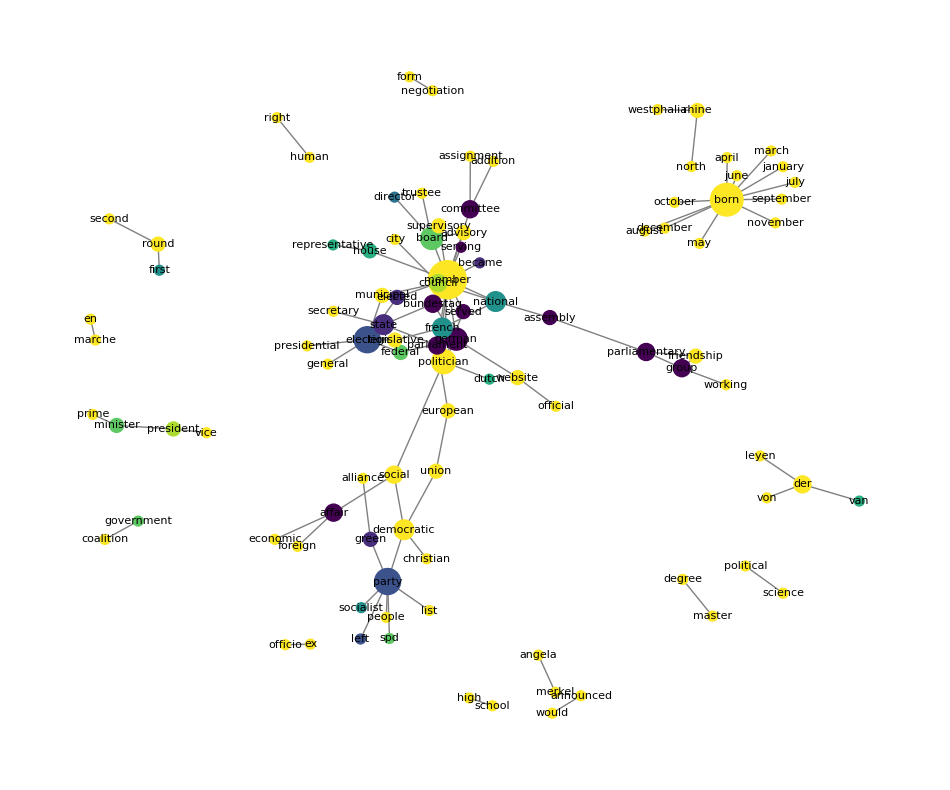

In [25]:
# Bigram visualisation
# https://github.com/oliviatan29/network_analysis/blob/main/Network%20Analysis%20-%20Indonesian%20Food%20Ingredients.ipynb
# Create dictionary of edges and their weights
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))
    
# Use node degree as the node size

fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=2)

d = dict(G.degree)

nx.draw(G, pos,
        font_size=8,
        width=1,
        edge_color='grey',
        node_color = nodes_df['topic'].cat.codes,
        with_labels = True, 
        nodelist=list(d.keys()), 
        node_size=[v * 50 for v in d.values()])
plt.show()

In [26]:
# 0 (topic 1) - dark purple
# NA - yellow (common across all documents)

print('Number of nodes per topic:')
print(nodes_df['topic'].value_counts().sort_index())

Number of nodes per topic:
topic
0    10
1     4
2     3
3     1
5     4
6     4
7     5
8     2
     68
Name: count, dtype: int64


## Testing model

In [98]:
# probability of a word belonging to a topic
test_words = ['european', 'woman', 'served', 'elected']
for word in test_words:
    try:
        t_probability = lda_model.get_term_topics(word)
        print('\nWord:', word, ' - belongs to:')
        for topic, prob in t_probability:
             print('Topic: {} \nProbability: {}\n'.format(topic, prob))
    except IndexError:
        pass


Word: european  - belongs to:
Topic: 0 
Probability: 0.06170090660452843

Topic: 8 
Probability: 0.012142736464738846


Word: woman  - belongs to:
Topic: 1 
Probability: 0.010541661642491817

Topic: 3 
Probability: 0.014930302277207375

Topic: 5 
Probability: 0.01693888194859028


Word: served  - belongs to:
Topic: 1 
Probability: 0.014407980255782604

Topic: 7 
Probability: 0.011427057906985283


Word: elected  - belongs to:
Topic: 1 
Probability: 0.016755618155002594

Topic: 2 
Probability: 0.026537824422121048

Topic: 6 
Probability: 0.012585447169840336

Topic: 7 
Probability: 0.01687142811715603



In [50]:
query = 'Leadership is the ability of an individual or a group of people to influence and guide followers or members of an organization, society or team.'
vec_bow = dictionary.doc2bow(query.lower().split())

# convert the query to LSI space
vec_lda = lda_model[vec_bow]  
# This shows how the query relates to the topics
vec_lda

[(0, 0.03490614),
 (1, 0.034060966),
 (2, 0.034278072),
 (3, 0.86267275),
 (4, 0.03408209)]